In [1]:
import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite

######################## swap low and medium

size_low_image_tif = np.array(Image.open("matching_images/low/extract/green_template_matched_region.tif")).shape
size_med_image_tif = np.array(Image.open("matching_images/medium/extract/green_template_matched_region.tif")).shape
size_top_image_tif = np.array(Image.open("matching_images/top/extract/green_template_matched_region.tif")).shape

In [2]:
size_low_image_tif

(2494, 3679)

In [3]:
size_med_image_tif

(4000, 5900)

In [4]:
size_top_image_tif

(1547, 2282)

# 1. Define Differential Entropy

https://stats.stackexchange.com/questions/235270/entropy-of-an-image

https://arxiv.org/ftp/arxiv/papers/1609/1609.01117.pdf

In [5]:
def deldensity(image):
    
    # differentiate
    fx = (image[:,2:] - image[:,:-2])[1:-1,:]
    fy = (image[2:,:] - image[:-2,:])[:,1:-1]
    
    # bin the gradient for faster computation
    diff_range = np.max([np.abs(fx.min()), np.abs(fx.max()), np.abs(fy.min()), np.abs(fy.max())])
    diff_range = 2**(int(np.log2(diff_range))+1) # always power of 2
    n_bins = min(1024, 2*diff_range+1)
    # Centering the bins is necessary because else all value will lie on
    # the bin edges thereby leading to assymetric artifacts
    dbin = 0.5
    r = diff_range + dbin
    delDensity, xedges, yedges = np.histogram2d(fx.flatten(), fy.flatten(), bins = n_bins, range = [[-r,r], [-r,r]])
    
    return delDensity, xedges, yedges

def H_image(image, plot=False):

    delDensity, xedges, yedges = deldensity(image)
    
    # compute entropy
    p = (delDensity / np.sum(delDensity)).T
    H = - 1/2 * np.sum(p[p.nonzero() ] * np.log2(p[p.nonzero()]))
    
    if plot:
        fig = plt.figure()
        ax = [
            fig.add_subplot(221, title = f"Original Image"),
            fig.add_subplot(222, title = "Gradient")
        ]
        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[1].imshow(delDensity, cmap=plt.cm.gray, vmin = 0, interpolation='nearest', origin='lower',
                extent = [ xedges[0], xedges[-1], yedges[0], yedges[-1]])
        fig.tight_layout()
        plt.show()
        
    return H

## 2. Comparing different heights (jpg files from online converter)

In [6]:
levels = ['low', 'medium', 'top']
channels = ['green', 'red', 'red edge', 'nir']


for channel in channels:
    print(f'-------------------------------- channel: {channel} --------------------------------')
        
    for level in levels:
        
        image = Image.open(f"matching_images/{level}/extract/jpg/{channel}_template_matched_region.jpg")
        image = np.array(image, dtype=int)
            
        print(f'Level {level}: {H_image(image, plot=False)}')

-------------------------------- channel: green --------------------------------
Level low: 4.658436351343609
Level medium: 5.154033075231657
Level top: 4.824093173152952
-------------------------------- channel: red --------------------------------
Level low: 4.771264315342844
Level medium: 5.222235514448041
Level top: 5.011945042263724
-------------------------------- channel: red edge --------------------------------
Level low: 4.713750163376357
Level medium: 5.211943551424208
Level top: 4.99490562276438
-------------------------------- channel: nir --------------------------------
Level low: 4.498882487447538
Level medium: 5.135395752415755
Level top: 4.48729444099551


## 3. Using directly tiff files

In [7]:
def preprocess_tiff(path):
    
    # open image
    image = Image.open(path)
    image = np.array(image)
    
    # replace 255 with median (~0.2% of pixels)
    image[image==255.] = np.nan
    image[np.isnan(image)] = np.nanmedian(image)
    
    #scale between 0 and 255
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = (image*255).astype(int)
    
    # expand size
    image = Image.fromarray(image).resize(size_low_image_tif)
    
    return np.array(image, dtype=int)

In [8]:
levels = ['low', 'medium', 'top']
channels = ['green', 'red', 'red edge', 'nir']
results = {c: {} for c in channels}


for channel in channels:
    print(f'-------------------------------- channel: {channel} --------------------------------')
        
    for level in levels:
            
        image = preprocess_tiff(f"matching_images/{level}/extract/{channel}_template_matched_region.tif")
        entropy = H_image(image, plot=False)
        results[channel][level] = entropy
        
        print(f'Level {level}: {entropy}')

-------------------------------- channel: green --------------------------------
Level low: 4.650614105648631
Level medium: 4.836221276495916
Level top: 4.443217552970657
-------------------------------- channel: red --------------------------------
Level low: 4.783990797791145
Level medium: 5.039694948332582
Level top: 4.622273248789876
-------------------------------- channel: red edge --------------------------------
Level low: 4.711235387521808
Level medium: 4.862575062118339
Level top: 4.5611546746628555
-------------------------------- channel: nir --------------------------------
Level low: 4.48397704362685
Level medium: 4.786459344682363
Level top: 4.228526063908106


## Plot results

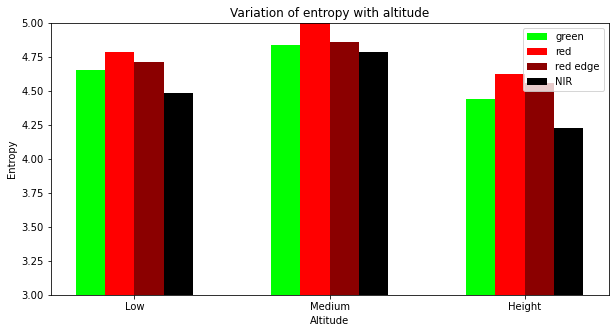

In [9]:
green, red, red_edge, nir = results['green'].values(), results['red'].values(), results['red edge'].values(), results['nir'].values()

# Position of bars on x-axis
ind = np.arange(3)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.15     

# Plotting
plt.bar(ind, green , width, label='green', color='lime')
plt.bar(ind + width, red, width, label='red', color='red')
plt.bar(ind + 2*width, red_edge, width, label='red edge', color='darkred')
plt.bar(ind + 3*width, nir, width, label='NIR', color='black')

plt.xlabel('Altitude')
plt.ylabel('Entropy')
plt.title('Variation of entropy with altitude')

plt.xticks(ind + 1.5*width, ('Low', 'Medium', 'Height'))
plt.ylim(3, 5)

plt.legend(loc='best')
plt.show()

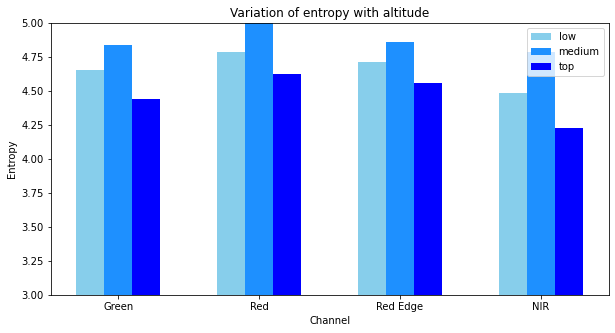

In [10]:
low, medium, top = [results[c]['low'] for c in channels], [results[c]['medium'] for c in channels], [results[c]['top'] for c in channels]

# Position of bars on x-axis
ind = np.arange(4)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.2     

# Plotting
plt.bar(ind, low, width, label='low', color='skyblue')
plt.bar(ind + width, medium, width, label='medium', color='dodgerblue')
plt.bar(ind + 2*width, top, width, label='top', color='blue')

plt.xlabel('Channel')
plt.ylabel('Entropy')
plt.title('Variation of entropy with altitude')

plt.xticks(ind + width, ('Green', 'Red', 'Red Edge', 'NIR'))
plt.ylim(3, 5)

plt.legend(loc='best')
plt.show()